In [36]:
from kaveh.behavioral.oculomotor.session import session
from kaveh.toolbox import find_file
from neo.io import Spike2IO
from matplotlib import pyplot as plt
import numpy as np
import csv


In [37]:
import quantities as pq

def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
    cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []
    bin_cs_prob = []
    bin_size = []
    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_prob = cs_count*1.0/bin_times.size
            bin_cs_prob.append(cs_prob)
            bin_cs_counts.append(cs_count)
            bin_size.append(bin_times.size)
        else:
            bin_cs_counts.append(0)
            bin_cs_prob.append(0)
            bin_size.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
    bin_cs_prob = np.array(bin_cs_prob)
    bin_size = np.array(bin_size)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return (bin_cs_counts, bin_cs_prob, bin_size)

In [38]:
import os
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
import sklearn.preprocessing as pp

In [39]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
with open('../data/neurons_david_data_with_spike_train.csv', 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader))
file_names = np.array([fn[0] for fn in csv_content])

for i, fn in enumerate(file_names):
    print('{}: {}'.format(i, fn))

0: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O22/O22_2Adapt_BW5L_FW5LCFRDone.smr
1: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O22/O22_2PreAdaptCFRDone.smr
2: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt40pct.smr
3: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt30pct.smr
4: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_preadapt.smr
5: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O13/O13_3_adapt40pctB.smr
6: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O41/O41_1_FW5L_BW5R_A.smr
7: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O41/O41_1_pre.smr
8: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O29/O29_4Adapt_FW5L_BW5RCFR611sec.smr
9: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Oscar/O29/O29_4PreAdaptCFRDone.smr
10: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K14/error_direction/K14_1_directiona

In [41]:
f_index =[10, 12, 13, 16, 18, 19, 21, 23, 26, 28, 30, 31, 34, 41, 43, 45, 46, 86, 91, 94, 98]
for i in f_index:
    print('{}: {}'.format(i, file_names[i]))

10: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K14/error_direction/K14_1_directionaltest.smr
12: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K33/error_direction/K33_1dirtest.smr
13: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K33/error_direction/K33_2dirtest.smr
16: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K45/error_direction/K45_1_ErrorDirectionTest.smr
18: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K21/error_direction/K21_2_directionaltest.smr
19: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K69/error_direction/K69_1_DirTuning.smr
21: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K40/error_direction/K40_1_Dirtuning.smr
23: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K16/error_direction/K16_2_directionaltest.smr
26: /mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Step/S36/error_direction/S36_1_directionalt

In [42]:
non_iss_targets_for_file = {}
iss_targets_for_file = {}
david_neurons_source = '/mnt/data/temp/kaveh/david_neurons/'
bin_cs_counts_iss_for_file = {}
for ff in file_names[f_index]:
    
    f_name = find_file(os.path.basename(ff), '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data')
    f_name_session = find_file(os.path.basename(ff)+'.pkl.session.pkl', david_neurons_source)
    f_name_gmm_csv = find_file(os.path.basename(ff)+'.pkl.GMM.CS.csv', david_neurons_source)
    print(f_name)

    print(f_name_session)
    print(f_name_gmm_csv)
    
    neo_reader = Spike2IO(filename=f_name)
    neo_data = neo_reader.read()
    data_block = neo_data[0]
    seg = data_block.segments[0]

    # Load cs times from GMM csv files
    import csv
    t_signal = seg.analogsignals[-1].times

    with open(f_name_gmm_csv, 'r') as csv_f:
        reader = csv.reader(csv_f)
        csv_content = np.array(list(reader), dtype=np.int64)

    cs_indices_gmm = np.squeeze(csv_content[np.where(csv_content[:,1] == 1), 0])
    cs_times_gmm = t_signal[cs_indices_gmm]
    cs_times_gmm.shape

    with open(f_name_session, 'rb') as input:
        try:
            mysess = pickle.load(input, encoding='latin1')
        except TypeError:
            mysess = pickle.load(input)

    # find inra-saccadic target jumps. For each saccade, check if that saccade is accompanied by a simultaneous target jump.
    # If so, it is an intra-saccadic target_jump. 
    # check 25 ms before and after the saccade onset and offset for the target jump onset and offset. if found, the target jump is intra-saccadic
    import numpy as np
    import quantities as pq
    iss_range = pq.quantity.Quantity(0.030, 's')
    iss_targets = []
    iss_saccades = []
    saccades_with_no_iss_target = []
    for i, (son, soff) in enumerate(zip(mysess.saccade_onset_times, mysess.saccade_offset_times)):
        iss_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
                                                                 mysess.target_onset_times > son - iss_range), 
                                                  np.logical_and(mysess.target_offset_times < soff + iss_range, 
                                                                 mysess.target_offset_times > soff - iss_range)))[0])
        if iss_targets[-1].size != 0:
            iss_saccades.append(i)
        if iss_targets[-1].size == 0:
            saccades_with_no_iss_target.append(i)

    iss_targets = np.squeeze(np.array([isst[0] for isst in iss_targets if isst.size != 0]))

    iss_multipeak_targets = []
    for i, (son, soff) in enumerate(zip(mysess.multipeak_saccade_onsets, mysess.multpeak_saccade_offsets)):
        iss_multipeak_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
                                                                 mysess.target_onset_times > son - iss_range), 
                                                  np.logical_and(mysess.target_offset_times < soff + iss_range, 
                                                                 mysess.target_offset_times > soff - iss_range)))[0])

    iss_multipeak_targets = np.squeeze(np.array([isst[0] for isst in iss_multipeak_targets if isst.size != 0]))

    non_iss_target_jumps = np.setdiff1d(np.arange(mysess.target_onset_times.size), np.union1d(iss_targets, iss_multipeak_targets))

    # calculate target vectors (target_offset_position - target_onset_position)
    ton_VT = np.squeeze(mysess.VT[mysess.target_onsets[non_iss_target_jumps]])
    toff_VT = np.squeeze(mysess.VT[mysess.target_offsets[non_iss_target_jumps]])

    ton_HT = np.squeeze(mysess.HT[mysess.target_onsets[non_iss_target_jumps]])
    toff_HT = np.squeeze(mysess.HT[mysess.target_offsets[non_iss_target_jumps]])

    target_jump_H = toff_HT - ton_HT
    target_jump_V = toff_VT - ton_VT

    target_jump_dir = np.arctan2(target_jump_V, target_jump_H) * 180 / np.pi

    target_jump_mag = np.linalg.norm(np.vstack((target_jump_H, target_jump_V)), axis = 0)

    bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))

    bin_ind[bin_ind == 8] = 0

    non_iss_targets_for_file[ff] = get_bin_cs_counts(0.160, mysess.target_offset_times[non_iss_target_jumps],
                                                bin_ind, np.unique(bin_ind), cs_times_gmm)
    
    # calculate target vectors (target_offset_position - target_onset_position)
    ton_VT = np.squeeze(mysess.VT[mysess.target_onsets[iss_targets]])
    toff_VT = np.squeeze(mysess.VT[mysess.target_offsets[iss_targets]])

    ton_HT = np.squeeze(mysess.HT[mysess.target_onsets[iss_targets]])
    toff_HT = np.squeeze(mysess.HT[mysess.target_offsets[iss_targets]])

    target_jump_H = toff_HT - ton_HT
    target_jump_V = toff_VT - ton_VT

    target_jump_dir = np.arctan2(target_jump_V, target_jump_H) * 180 / np.pi

    target_jump_mag = np.linalg.norm(np.vstack((target_jump_H, target_jump_V)), axis = 0)

    bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))

    bin_ind[bin_ind == 8] = 0
    
    iss_targets_for_file[ff] = get_bin_cs_counts(0.200, mysess.target_offset_times[iss_targets],
                                                bin_ind, np.unique(bin_ind), cs_times_gmm)
    bin_cs_counts_iss_for_file[bf] = get_bin_cs_counts(0.200, mysess.saccade_offset_times[iss_saccades], iss_saccades_bin_ind, error_dir_bin_numbers, cs_times)


/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2008_Random/Kimo/K14/error_direction/K14_1_directionaltest.smr
/mnt/data/temp/kaveh/david_neurons/K14/error_direction/K14_1_directionaltest.smr.pkl.session.pkl
/mnt/data/temp/kaveh/david_neurons/K14/error_direction/K14_1_directionaltest.smr.pkl.GMM.CS.csv


NameError: name 'iss_saccades_bin_ind' is not defined

In [ ]:
tunings_non_iss = []
for val in non_iss_targets_for_file.values():
    print(val[1])
    print(np.argmax(val[1]))
    zero_idx = np.argmax(val[1])
    tunings_non_iss.append(np.roll(val[1], 3-zero_idx , axis=0))
    
tunings_iss = []
for val in iss_targets_for_file.values():
    print(val[1])
    print(np.argmax(val[1]))
    zero_idx = np.argmax(val[1])
    tunings_iss.append(np.roll(val[1], 3-zero_idx , axis=0))



In [31]:
tunings_iss = np.array(tunings_iss)
tunings_non_iss = np.array(tunings_non_iss)

In [32]:
mean_non_iss = np.mean(tunings_non_iss, axis = 0)
sd_non_iss = np.std(tunings_non_iss, axis = 0)/np.sqrt(tunings_non_iss.shape[0]-1)

mean_iss = np.mean(tunings_iss, axis = 0)
sd_iss = np.std(tunings_iss, axis = 0)/np.sqrt(tunings_iss.shape[0]-1)

<IPython.core.display.Javascript object>


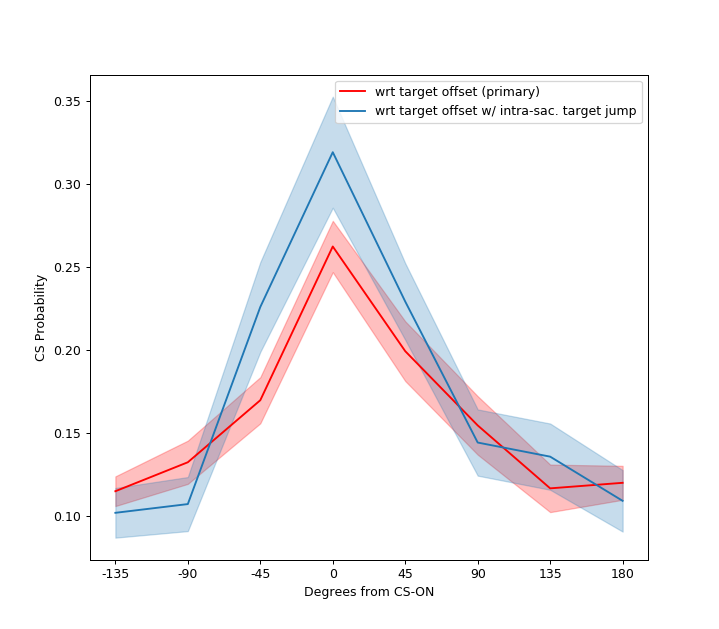

In [33]:
x = [-135, -90, -45, 0, 45, 90, 135, 180]
plt.figure(figsize=(8,7))
l = plt.plot(x, mean_non_iss, 'r')
plt.fill_between(x, mean_non_iss - sd_non_iss, mean_non_iss + sd_non_iss, color=l[0].get_color(), alpha=0.25)

l = plt.plot(x, mean_iss)
plt.fill_between(x, mean_iss - sd_iss, mean_iss + sd_iss, color=l[0].get_color(), alpha=0.25)
plt.xticks(x,x)

plt.xlabel('Degrees from CS-ON')
plt.ylabel('CS Probability')
plt.legend(['wrt target offset (primary)','wrt target offset w/ intra-sac. target jump'])

<IPython.core.display.Javascript object>


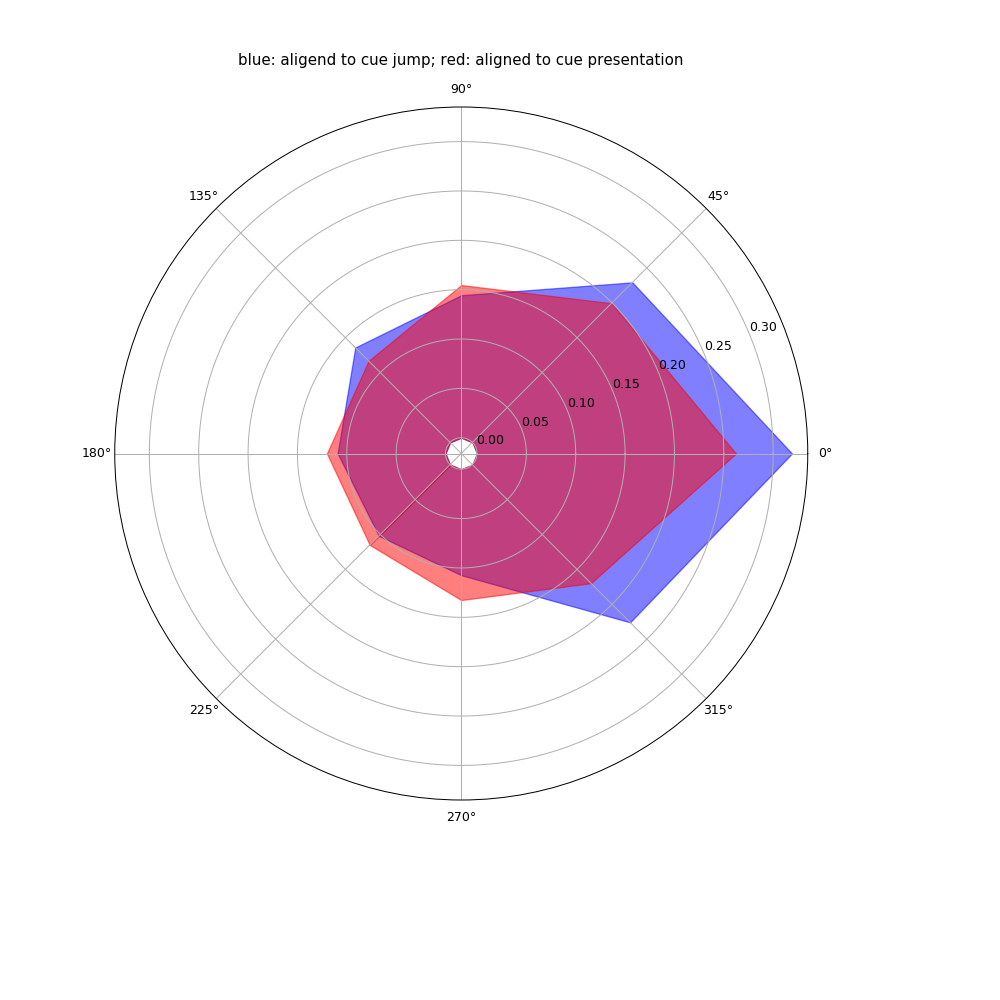

Text(0.5,1.05,u'blue: aligend to cue jump; red: aligned to cue presentation')

In [34]:
theta = np.array([-135, -90, -45, 0, 45, 90, 135, 180])*np.pi/180
plt.figure(figsize=(10,10))
plt.polar(np.hstack((theta, theta[0])), np.hstack((mean_iss , mean_iss[0])), alpha = 0.02,color = 'b' )
plt.fill_between( np.hstack((theta, theta[0])),0, np.hstack((mean_iss , mean_iss[0])), alpha = 0.5, color = 'b')

plt.polar(np.hstack((theta, theta[0])), np.hstack((mean_non_iss , mean_non_iss[0])), alpha = 0.02,color = 'r' )
plt.fill_between(np.hstack((theta, theta[0])),0, np.hstack((mean_non_iss , mean_non_iss[0])), alpha = 0.5, color = 'r')
plt.title('blue: aligend to cue jump; red: aligned to cue presentation')

In [35]:
plt.savefig('../data/plots/Saliency_stuff/cs_tuning_with_respect_to_primary_target_and_target_jump_polar_200ms.png')
plt.savefig('../data/plots/Saliency_stuff/cs_tuning_with_respect_to_primary_target_and_target_jump_polar_200ms.svg')


In [106]:
# plt.title('n = {}'.format(len(f_index)))
plt.title('n = 24')

Text(0.5,1,u'n = 24')

In [107]:
plt.savefig('../data/plots/target_aligned_tuning_with_gmm_detected_cs_21_neurons.png')

<IPython.core.display.Javascript object>


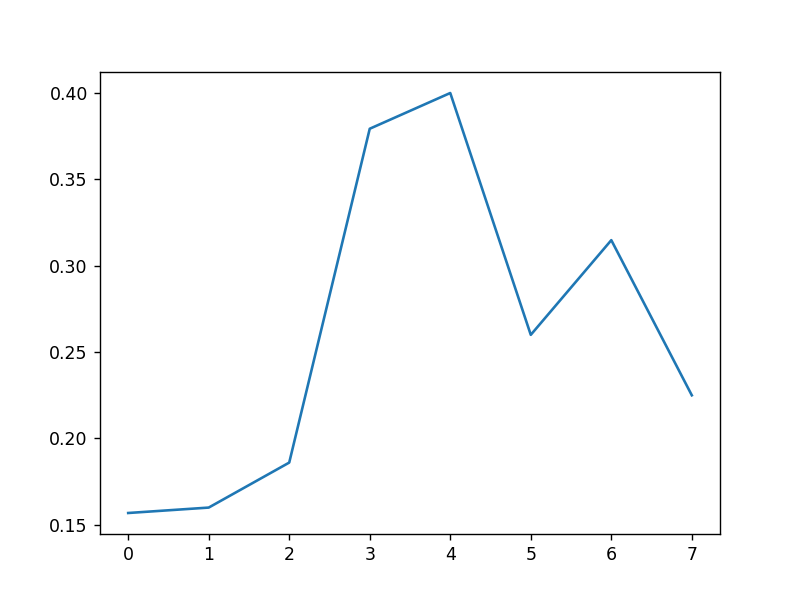

In [47]:
plt.figure()
plt.plot(iss_targets_for_file[file_names[f_index[9]]][1])

<IPython.core.display.Javascript object>


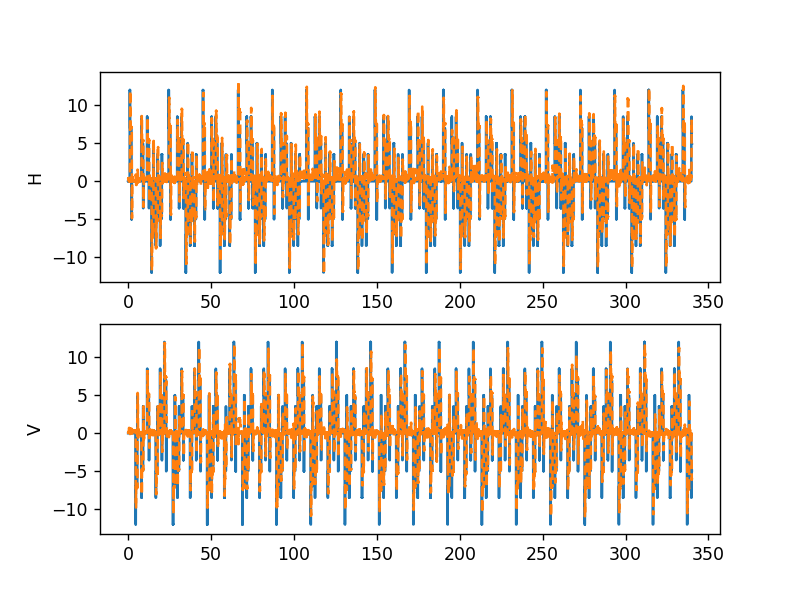

In [75]:
import gc
gc.collect()

# ff = file_names[51]
f_name_session = find_file('B091908_1_1500_List.smr'+'.pkl.session.pkl', '../data/david_neurons')


with open(f_name_session, 'rb') as input:
    try:
        mysess = pickle.load(input, encoding='latin1')
    except TypeError:
        mysess = pickle.load(input)


plt.figure()

ax1 = plt.subplot(211)
plt.plot(mysess.t_HT, mysess.HT)
plt.plot(mysess.t_HE, mysess.HE, '--')
# plt.eventplot(mysess.target_onset_times[non_iss_target_jumps], linelengths=40, colors='r', alpha = 0.3)
plt.ylabel('H')

ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
plt.plot(mysess.t_VT, mysess.VT)
plt.plot(mysess.t_VE, mysess.VE, '--')
plt.ylabel('V')
plt.show()

In [61]:
# calculate target vectors (target_offset_position - target_onset_position)
ton_VT = np.squeeze(mysess.VT[mysess.target_onsets[non_iss_target_jumps]])
toff_VT = np.squeeze(mysess.VT[mysess.target_offsets[non_iss_target_jumps]])

ton_HT = np.squeeze(mysess.HT[mysess.target_onsets[non_iss_target_jumps]])
toff_HT = np.squeeze(mysess.HT[mysess.target_offsets[non_iss_target_jumps]])

target_jump_H = toff_HT - ton_HT
target_jump_V = toff_VT - ton_VT

target_jump_dir = np.arctan2(target_jump_V, target_jump_H) * 180 / np.pi

target_jump_mag = np.linalg.norm(np.vstack((target_jump_H, target_jump_V)), axis = 0)




In [57]:
t_start = 0
t_end = 5000
mysess = session(HT[np.where(np.logical_and((t_HT > t_start), (t_HT <= t_end)))], t_HT[np.where(np.logical_and((t_HT > t_start), (t_HT <= t_end)))],
                 VT[np.where(np.logical_and((t_VT > t_start), (t_VT <= t_end)))], t_VT[np.where(np.logical_and((t_VT > t_start), (t_VT <= t_end)))],
                 HE[np.where(np.logical_and((t_HE > t_start), (t_HE <= t_end)))], t_HE[np.where(np.logical_and((t_HE > t_start), (t_HE <= t_end)))],
                 VE[np.where(np.logical_and((t_VE > t_start), (t_VE <= t_end)))], t_VE[np.where(np.logical_and((t_VE > t_start), (t_VE <= t_end)))], fs, dt)
mysess._cut_to_min_size()
mysess._calc_target_velocity()
mysess._calc_saccade_velocity()
mysess._detect_target_jumps()
mysess._detect_saccades()
mysess._calc_error_vectors()


In [62]:
bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))

In [73]:
bin_ind [bin_ind == 8] = 0

In [72]:
np.arange(-180 + 22.5, 180, 45)

array([-157.5, -112.5,  -67.5,  -22.5,   22.5,   67.5,  112.5,  157.5])

In [74]:
np.unique(bin_ind)

array([0, 1, 2, 3, 4, 5, 6, 7])

<IPython.core.display.Javascript object>


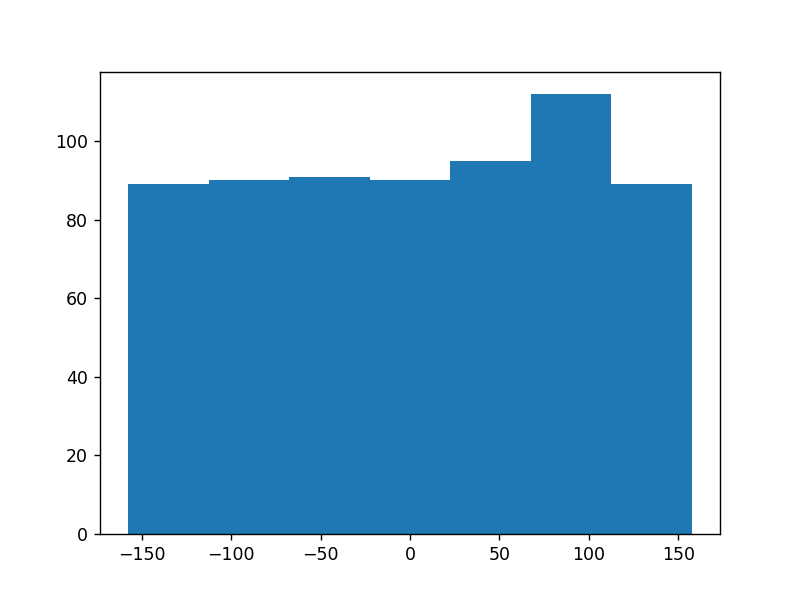

(array([ 89.,  90.,  91.,  90.,  95., 112.,  89.]),
 array([-157.5, -112.5,  -67.5,  -22.5,   22.5,   67.5,  112.5,  157.5]),
 <a list of 7 Patch objects>)

In [66]:
plt.figure()
plt.hist(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))

In [63]:
import quantities as pq

def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
    cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []
    bin_cs_prob = []
    bin_size = []
    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_prob = cs_count*1.0/bin_times.size
            bin_cs_prob.append(cs_prob)
            bin_cs_counts.append(cs_count)
            bin_size.append(bin_times.size)
        else:
            bin_cs_counts.append(0)
            bin_cs_prob.append(0)
            bin_size.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
    bin_cs_prob = np.array(bin_cs_prob)
    bin_size = np.array(bin_size)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return (bin_cs_counts, bin_cs_prob, bin_size)


In [64]:
get_bin_cs_counts(0.200, mysess.target_offset_times[non_iss_target_jumps], bin_ind, np.array([1, 5]), cs_times)

(array([17, 18]), array([0.19101124, 0.18947368]), array([89, 95]))

In [123]:
bin_number = 7
saccade_response_delays_to_target_presentation = []
saccade_delays_target_offset_times = []
for toff in mysess.target_offset_times[non_iss_target_jumps][bin_ind == bin_number]:
    delay_to_next_saccade = mysess.saccade_onset_times[np.argmax(mysess.saccade_onset_times > toff)] - toff
    delay_to_next_target_jump = mysess.target_onset_times[non_iss_target_jumps][bin_ind == bin_number][np.argmax(mysess.target_onset_times[non_iss_target_jumps][bin_ind == bin_number] > toff)] - toff
    if delay_to_next_saccade <= delay_to_next_target_jump and delay_to_next_saccade <= 0.6:
        saccade_response_delays_to_target_presentation.append(delay_to_next_saccade)
        saccade_delays_target_offset_times.append(toff)

saccade_response_delays_to_target_presentation = np.squeeze(np.array(saccade_response_delays_to_target_presentation))
saccade_delays_target_offset_times = np.squeeze(np.array(saccade_delays_target_offset_times))

In [124]:
saccade_delays_target_offset_times =  pq.quantity.Quantity(saccade_delays_target_offset_times, 's')

In [130]:
bins = np.arange(0, np.max(saccade_response_delays_to_target_presentation), 0.050)
bin_ind_sac_delays = np.digitize(saccade_response_delays_to_target_presentation, bins = bins)
bins

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55])

In [131]:
bin_means = [saccade_response_delays_to_target_presentation[bin_ind_sac_delays == i].mean() for i in np.unique(bin_ind_sac_delays)]

In [132]:
(cs_counts, cs_probs, bin_sizes) = get_bin_cs_counts(0.150, saccade_delays_target_offset_times, bin_ind_sac_delays, np.unique(bin_ind_sac_delays), cs_times)

<IPython.core.display.Javascript object>


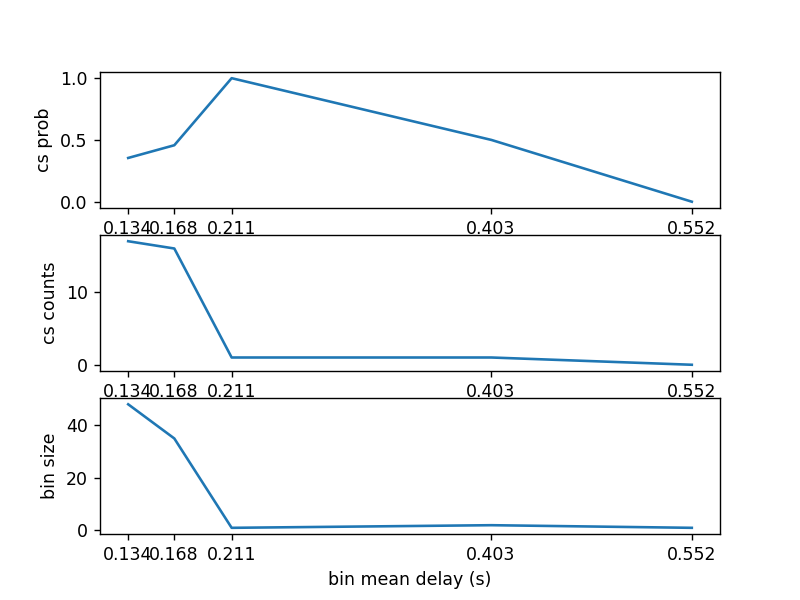

Text(0.5,0,u'bin mean delay (s)')

In [133]:
plt.figure()

plt.subplot(311)
plt.plot(bin_means,  cs_probs)
plt.xticks(np.round(bin_means,3))
plt.ylabel('cs prob')

plt.subplot(312)
plt.plot(bin_means,  cs_counts)
plt.xticks(np.round(bin_means,3))
plt.ylabel('cs counts')

plt.subplot(313)
plt.plot(bin_means,  bin_sizes)
plt.xticks(np.round(bin_means,3))
plt.ylabel('bin size')
plt.xlabel('bin mean delay (s)')

# plt.ylabel('prob of cs in 0.250 after target present')

<IPython.core.display.Javascript object>


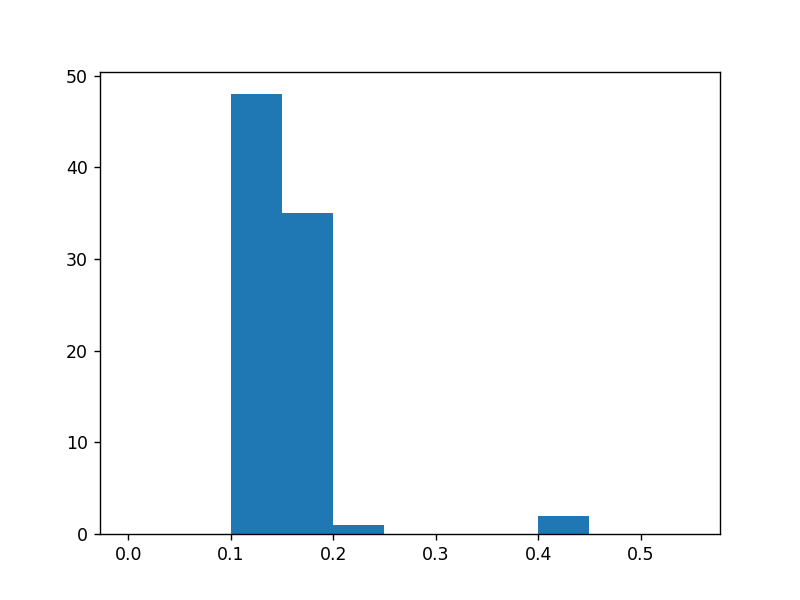

(array([ 0.,  0., 48., 35.,  1.,  0.,  0.,  0.,  2.,  0.,  0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55]),
 <a list of 11 Patch objects>)

In [129]:
plt.figure()
plt.hist(saccade_response_delays_to_target_presentation, bins = np.arange(0, np.max(saccade_response_delays_to_target_presentation), 0.05))

<IPython.core.display.Javascript object>


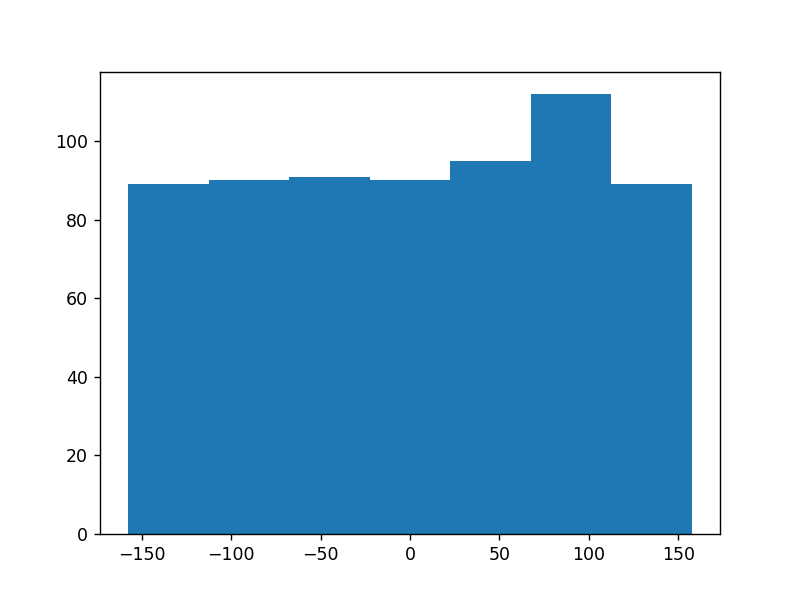

(array([ 89.,  90.,  91.,  90.,  95., 112.,  89.]),
 array([-157.5, -112.5,  -67.5,  -22.5,   22.5,   67.5,  112.5,  157.5]),
 <a list of 7 Patch objects>)

In [134]:
plt.figure()
plt.hist(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))


<IPython.core.display.Javascript object>


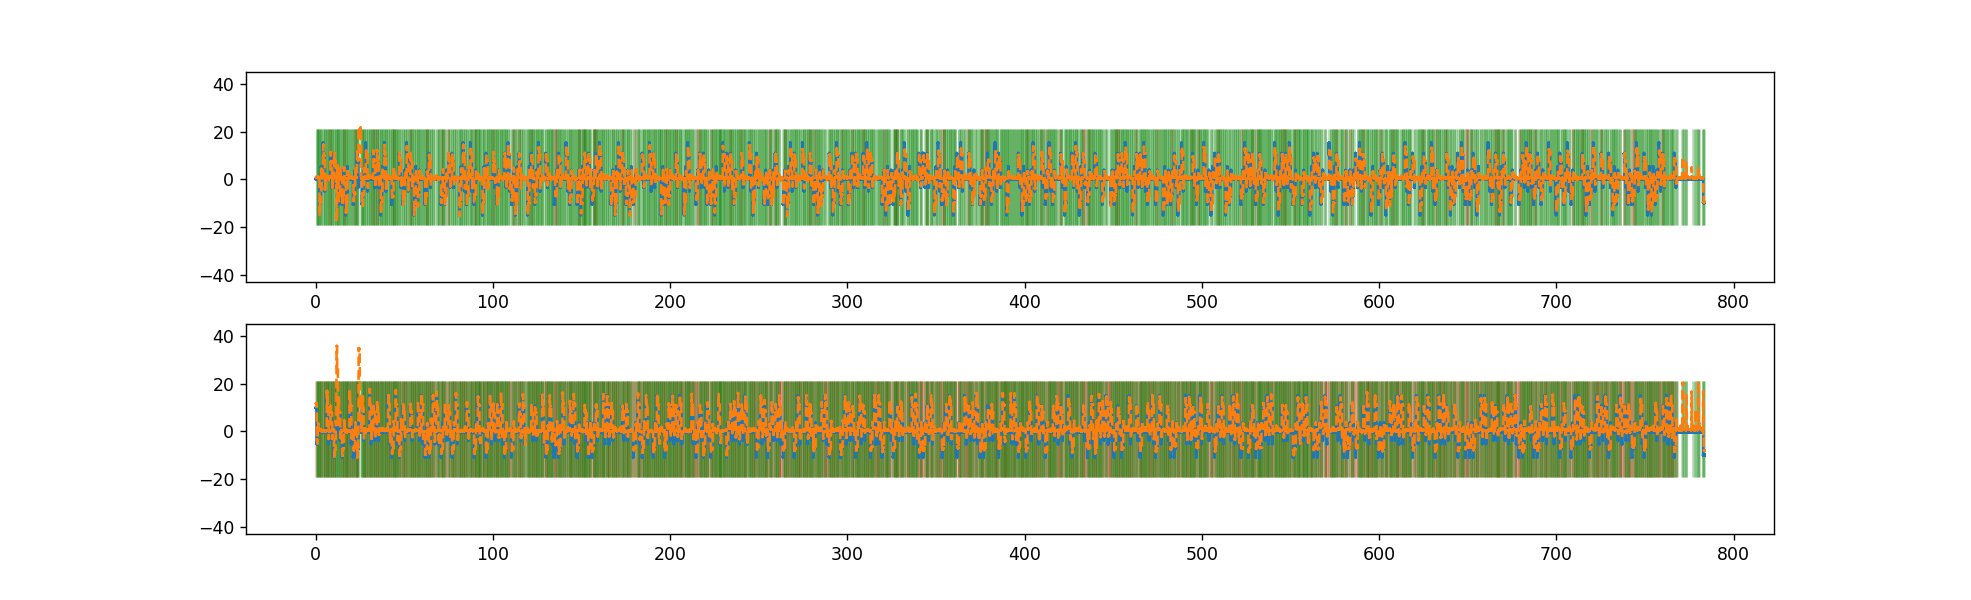

In [135]:
import gc
gc.collect()

plt.figure()
ax1 = plt.subplot(211)
plt.plot(t_HT, HT)
plt.plot(t_HE, HE, '--')
plt.eventplot(mysess.target_onset_times[non_iss_target_jumps][bin_ind == 5], linelengths=40, colors='r', alpha = 0.3)
plt.eventplot(mysess.saccade_onset_times, linelengths=40, color = 'g', alpha = 0.3)

ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
plt.plot(t_VT, VT)
plt.plot(t_VE, VE, '--')
plt.eventplot(mysess.target_onset_times[non_iss_target_jumps], linelengths=40, colors='r', alpha = 0.3)
plt.eventplot(mysess.saccade_onset_times, linelengths=40, color = 'g', alpha = 0.3)

plt.show()

In [140]:
# saving mysess
output_fn = f_name_csv + '.session.pkl'
with open(output_fn, 'wb') as output:
    print('writing {} ...'.format(output_fn))
    pickle.dump(mysess, output, pickle.HIGHEST_PROTOCOL)


writing ../data/david_neurons/K45/error_direction/K45_1_ErrorDirectionTest.smr.pkl.csv.session.pkl ...
